Training Accuracy: 0.994
Testing Accuracy: 0.982


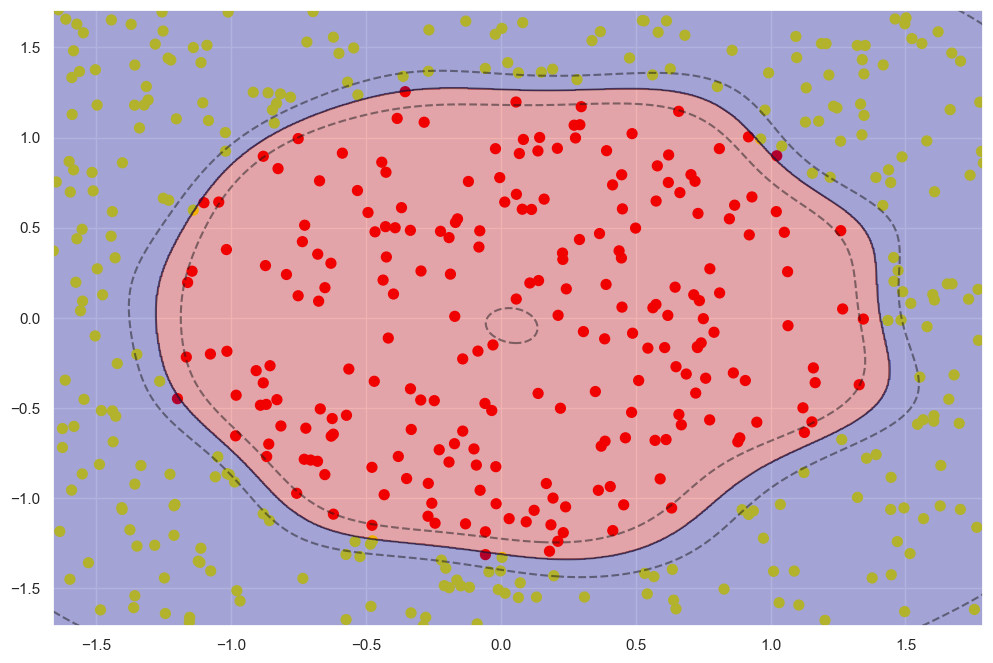

In [1]:
import numpy as np

class SVM:
    def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
        self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
                       'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                       'linear': lambda x,y: np.dot(x, y.T)}[kernel]
        self.C = C
        self.max_iter = max_iter

    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y * 2 - 1
        self.lambdas = np.zeros_like(self.y, dtype=float)
        self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y

        for _ in range(self.max_iter):
            for idxM in range(len(self.lambdas)):
                idxL = np.random.randint(0, len(self.lambdas))
                Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
                v0 = self.lambdas[[idxM, idxL]]
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
                u = np.array([-self.y[idxL], self.y[idxM]])
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
                self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)

            idx, = np.nonzero(self.lambdas > 1E-15)
            self.b = np.mean((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])

    def decision_function(self, X):
        return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

    def predict(self, X):
        return (np.sign(self.decision_function(X)) + 1) // 2

######### TESTS ############
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap

def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    return accuracy

def test_plot(X_train, y_train, X_test, y_test, svm_model, axes):
    plt.axes(axes)
    xlim = [np.min(X_train[:, 0]), np.max(X_train[:, 0])]
    ylim = [np.min(X_train[:, 1]), np.max(X_train[:, 1])]
    xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
    rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0

    svm_model.fit(X_train, y_train)
    z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
    plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
    
    y_train_pred = svm_model.predict(X_train)
    
    accuracy_train = calculate_accuracy(y_train, y_train_pred)
    print("Training Accuracy:", accuracy_train)

    y_test_pred = svm_model.predict(X_test)
    accuracy_test = calculate_accuracy(y_test, y_test_pred)
    print("Testing Accuracy:", accuracy_test)
    
    

import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


data = torch.load('exercise2.pt')
data = data.T
X = data[0: , :-1] #all rows & all columns except for the last one
y = data[0: , -1]


X = np.array(X)
y = np.array(y)

# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
#y = scaler.fit_transform(y)

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


fig, axs = plt.subplots(figsize=(12,8))
test_plot(X_train, y_train, X_test, y_test, SVM(kernel='rbf', C=10, max_iter=60, gamma=3), axs)
